In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.formula.api import ols

In [2]:
# Homes contains data on home sales, zipcodes is for encoding cities later
homes = pd.read_csv('data/kc_house_data.csv')
zipcodes = pd.read_csv('data/zips.csv')

# Columns suggested to drop by project description
cols_to_drop = (['id','date','view','sqft_above','sqft_basement','yr_renovated',
                'lat','long','sqft_living15','sqft_lot15'])
homes = homes.drop(cols_to_drop,axis=1)

# Exchange the zipcode column for a city column based on zipcode
homes = homes.merge(zipcodes,how='left',on='zipcode').drop('zipcode',axis=1)
homes.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,city
0,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955,Seattle
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951,Seattle
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933,Kenmore
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965,Seattle
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987,Sammamish


In [3]:
# Check for N/A values
homes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   19221 non-null  object 
 7   condition    21597 non-null  object 
 8   grade        21597 non-null  object 
 9   yr_built     21597 non-null  int64  
 10  city         21597 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 2.0+ MB


In [4]:
# Waterfront is the only column with N/A values,
homes.waterfront.value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [5]:
# Replacing N/A with the mode
homes.waterfront.fillna('NO',inplace=True)

In [6]:
#Check basic statistics on the homes data
homes.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1970.999676
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,29.375234
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1951.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1975.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,1997.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,2015.000000


In [7]:
# One home has 33 bedrooms and only 1620 sq_ft living
homes[homes.bedrooms > 8]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,city
4092,599999.0,9,4.50,3830,6988,2.5,NO,Average,7 Average,1938,Seattle
4231,700000.0,9,3.00,3680,4400,2.0,NO,Average,7 Average,1908,Seattle
6073,1280000.0,9,4.50,3650,5000,2.0,NO,Average,8 Good,1915,Seattle
8537,450000.0,9,7.50,4050,6504,2.0,NO,Average,7 Average,1996,Seattle
8748,520000.0,11,3.00,3000,4960,2.0,NO,Average,7 Average,1918,Seattle
13301,1150000.0,10,5.25,4590,10920,1.0,NO,Average,9 Better,2008,Bellevue
15147,650000.0,10,2.00,3610,11914,2.0,NO,Good,7 Average,1958,Bellevue
15856,640000.0,33,1.75,1620,6000,1.0,NO,Very Good,7 Average,1947,Seattle
16830,1400000.0,9,4.00,4620,5508,2.5,NO,Average,11 Excellent,1915,Seattle
18428,934000.0,9,3.00,2820,4480,2.0,NO,Average,7 Average,1918,Seattle


In [8]:
# Treating the above case as a data entry issue and replacing it with the median 3
homes.loc[homes.bedrooms > 20,'bedrooms'] = 3

In [9]:
# Checking the values for column with object dtype
homes.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [10]:
# There is an ordered numeric in the column so this extracts it
homes.grade = homes.grade.apply(lambda x: int(x.split()[0]))

In [11]:
# Replaced the grade with the numeric value from above
homes.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [12]:
# Waterfront is binary so I encode 1 = Yes, 0 = No
Ord = OrdinalEncoder()
waterfronts = Ord.fit_transform(homes[['waterfront']])

# Default output is np array
waterfronts = pd.DataFrame(waterfronts,columns=['waterfront'])

# Remove the un-encoded column from dataset
homes = homes.drop('waterfront',axis=1)

In [13]:
# Checking the values for column with object dtype
homes.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [14]:
# Condition is categorical so I one hot encode
conditions = pd.get_dummies(homes.condition, prefix='cond',drop_first=True).astype(int)
conditions.columns = conditions.columns.str.replace(" ","")

# Remove the un-encoded column from dataset
homes = homes.drop('condition',axis=1)


In [15]:
# Checking the values for column with object dtype
homes.city.value_counts()

Seattle          8973
Renton           1597
Bellevue         1407
Kent             1201
Kirkland          977
Redmond           977
Auburn            911
Sammamish         800
Federal_Way       779
Issaquah          733
Maple_Valley      589
Woodinville       471
Snoqualmie        308
Kenmore           283
Mercer_Island     282
Enumclaw          233
North_Bend        220
Bothell           195
Duvall            190
Carnation         124
Vashon            117
Black_Diamond     100
Fall_City          80
Medina             50
Name: city, dtype: int64

In [16]:
# City is categorical so I one hot encode
cities = pd.get_dummies(homes.city,prefix='city',drop_first=True).astype(int)

# Remove the un-encoded column from dataset
homes = homes.drop('city',axis=1)

In [17]:
# All of the categoricals dropped and string columns changed to numeric
homes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   grade        21597 non-null  int64  
 7   yr_built     21597 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.5 MB


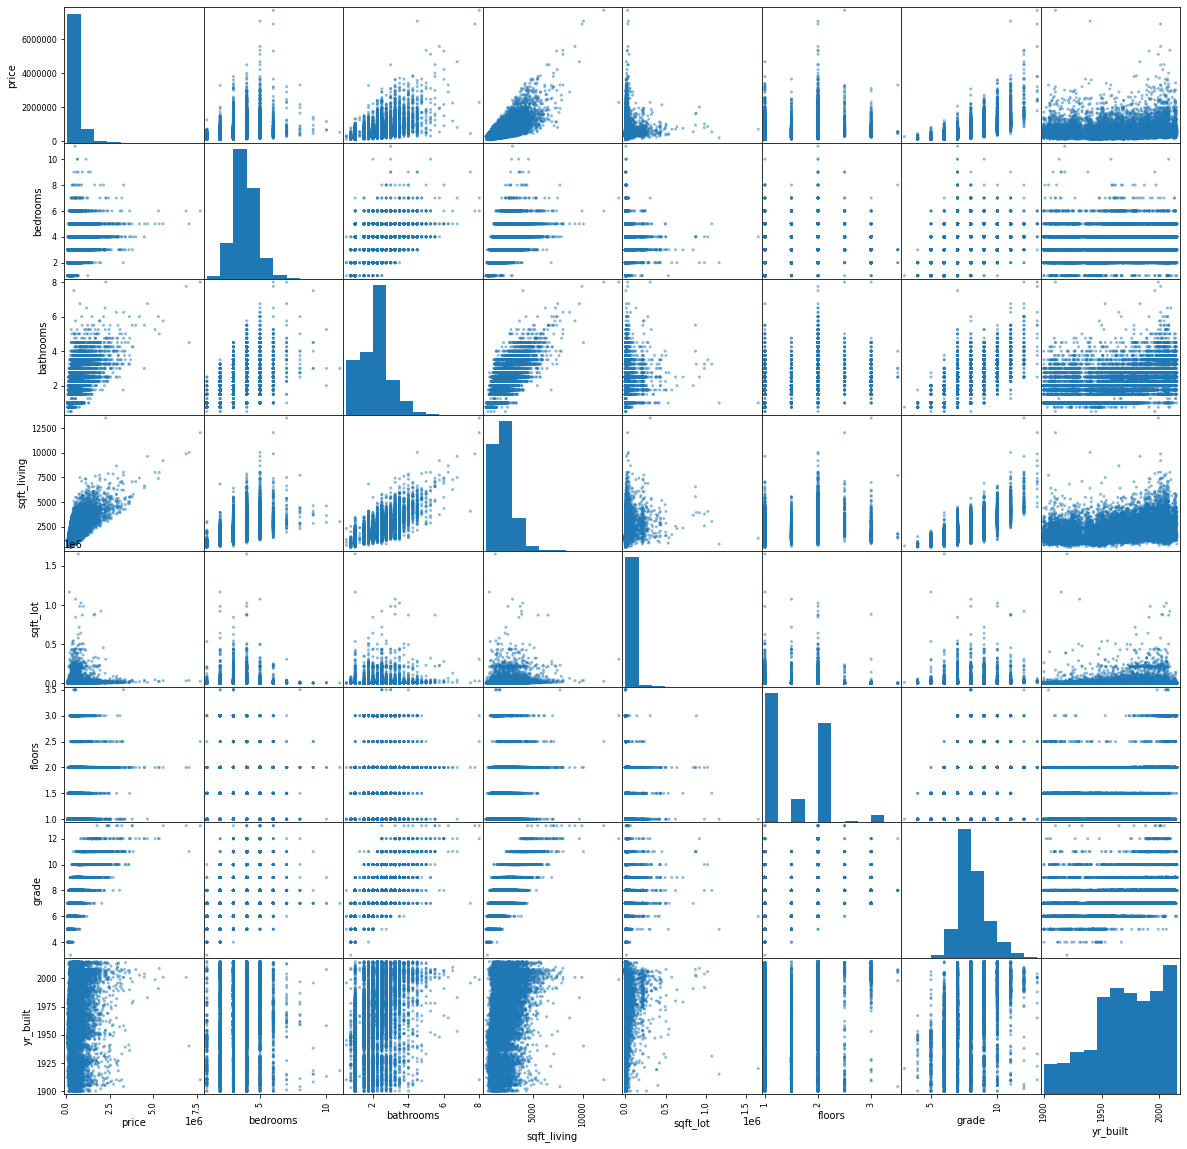

In [18]:
pd.plotting.scatter_matrix(homes,figsize=(20,20));

In [19]:
# Re-add all of the categorical columns in their encoded forms
homes = pd.concat([homes,waterfronts,conditions,cities],axis=1)

In [20]:
# Lots of encoded categoricals
homes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   bathrooms           21597 non-null  float64
 3   sqft_living         21597 non-null  int64  
 4   sqft_lot            21597 non-null  int64  
 5   floors              21597 non-null  float64
 6   grade               21597 non-null  int64  
 7   yr_built            21597 non-null  int64  
 8   waterfront          21597 non-null  float64
 9   cond_Fair           21597 non-null  int64  
 10  cond_Good           21597 non-null  int64  
 11  cond_Poor           21597 non-null  int64  
 12  cond_VeryGood       21597 non-null  int64  
 13  city_Bellevue       21597 non-null  int64  
 14  city_Black_Diamond  21597 non-null  int64  
 15  city_Bothell        21597 non-null  int64  
 16  city

In [21]:
# Creating the formula for the linear regression model using all predictors available
target = 'price'
predictors = homes.drop('price',axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum

In [22]:
# Creating and fitting the model
model = ols(formula=formula, data = homes).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1667.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:00:54   Log-Likelihood:            -2.9324e+05
No. Observations:               21597   AIC:                         5.866e+05
Df Residuals:                   21561   BIC:                         5.868e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            4.28e+06   1.32e+05     32.542      0.000    4.02e+06    4.54e+06
bedrooms           -4.256e+04   1880.787    -22.630      0.000   -4.62e+04   -3.89e+04
bathrooms           4.009e+04   3045.736     13.162      0.000    3.41e+04    4.61e+04
sqft_living          180.1180      2.945     61.161      0.000     174.346     185.890
sqft_lot               0.0718      0.034      2.089      0.037       0.004       0.139
floors              2.723e+04   3134.680      8.686      0.000    2.11e+04    3.34e+04
grade               1.008e+05   1965.002     51.285      0.000    9.69e+04    1.05e+05
yr_built           -2559.0668     68.075    -37.592      0.000   -2692.499   -2425.635
waterfront          7.539e+05   1.62e+04     46.436      0.000    7.22e+05    7.86e+05
cond_Fair          -7779.4832   1.49e+04     -0.523      0.601   -3.69e+04    2.14e+04
cond_Good           1.358e+04   3308.732      4.106      0.000    7099.626    2.01e+04
cond_Poor          -1.902e+04   3.56e+04     -0.534      0.594   -8.89e+04    5.08e+04
cond_VeryGood       5.184e+04   5246.628      9.880      0.000    4.16e+04    6.21e+04
city_Bellevue       3.517e+05   8333.691     42.199      0.000    3.35e+05    3.68e+05
city_Black_Diamond  8.232e+04   2.02e+04      4.083      0.000    4.28e+04    1.22e+05
city_Bothell        1.074e+05   1.51e+04      7.111      0.000    7.78e+04    1.37e+05
city_Carnation       1.14e+05   1.85e+04      6.162      0.000    7.77e+04     1.5e+05
city_Duvall         9.357e+04   1.53e+04      6.121      0.000    6.36e+04    1.24e+05
city_Enumclaw       2.932e+04   1.42e+04      2.069      0.039    1547.444    5.71e+04
city_Fall_City       1.62e+05   2.25e+04      7.212      0.000    1.18e+05    2.06e+05
city_Federal_Way   -2.834e+04   9353.648     -3.029      0.002   -4.67e+04      -1e+04
city_Issaquah       1.528e+05   9552.159     15.995      0.000    1.34e+05    1.72e+05
city_Kenmore        1.091e+05    1.3e+04      8.376      0.000    8.35e+04    1.35e+05
city_Kent           1.356e+04   8395.673      1.615      0.106   -2901.110       3e+04
city_Kirkland       2.638e+05   8842.133     29.834      0.000    2.46e+05    2.81e+05
city_Maple_Valley    4.04e+04   1.01e+04      3.983      0.000    2.05e+04    6.03e+04
city_Medina         1.259e+06    2.8e+04     45.003      0.000     1.2e+06    1.31e+06
city_Mercer_Island  4.738e+05   1.33e+04     35.670      0.000    4.48e+05       5e+05
city_North_Bend     1.052e+05   1.44e+04      7.303      0.000    7.69e+04    1.33e+05
city_Redmond        1.978e+05   8872.405     22.294      0.000     1.8e+05    2.15e+05
city_Renton          6.41e+04   7942.248      8.070      0.000    4.85e+04    7.97e+04
city_Sammamish      1.409e+05   9443.055     14.924      0.000    1.22e+05    1.59e+05
city_Seattle        1.991e+05   6902.5

In [23]:
# RMSE not included in summary above
print('Root mean squared error = ' +str(np.sqrt(model.mse_resid)))

Root mean squared error = 190980.78117707983
